# 3. Prédiction Batch et Visualisation - Chicago Taxi Demand

Ce notebook couvre la génération de prévisions batch pour la demande de taxis à Chicago et leur visualisation. Nous allons :
- Préparer les données d'entrée pour la prédiction batch
- Charger un modèle entraîné depuis Vertex AI Model Registry
- Générer des prédictions batch pour les périodes futures
- Analyser et visualiser les résultats de prévision
- Explorer les patterns spatiaux et temporels des prévisions

## 1. Configuration et Initialisation

Importons les bibliothèques nécessaires et initialisons l'environnement.

In [1]:
# Bibliothèques standards
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import holidays

# Google Cloud & Vertex AI
from google.cloud import aiplatform
from google.cloud import bigquery

# Visualisations avancées
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuration visuelle
%matplotlib inline
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = [12, 8]

## 2. Configuration du Projet GCP

Définissons les identifiants du projet et initialisons Vertex AI.

In [2]:
# Configuration du projet GCP
PROJECT_ID = "avisia-certification-ml-yde"  # Remplacez par votre Project ID
REGION = "europe-west1"
BQ_DATASET = "chicago_taxis"
LOCATION="EU"

# Tables BigQuery pour l'entrée et la sortie des prédictions
BQ_INPUT = f"bq://{PROJECT_ID}.{BQ_DATASET}.forecast_input"   # table contenant les timestamps futurs
BQ_OUTPUT = f"{PROJECT_ID}.{BQ_DATASET}"  # table où seront stockées les prédictions

# Initialisation de Vertex AI
aiplatform.init(project=PROJECT_ID, location=REGION)

# Initialisation du client BigQuery
client = bigquery.Client(project=PROJECT_ID)
# Créer le dataset s'il n'existe pas
dataset_id = f"{PROJECT_ID}.{BQ_DATASET}"
dataset = bigquery.Dataset(dataset_id)
dataset.location = LOCATION

try:
    dataset = client.create_dataset(dataset, exists_ok=True)
    print(f"✅ Dataset créé ou déjà existant : {dataset_id} (location={LOCATION})")
except Exception as e:
    print(f"❌ Erreur lors de la création du dataset : {e}")

print(f"✅ Environnement initialisé avec succès pour le projet {PROJECT_ID}")

/Users/gustavevernay/Desktop/Projets/Pro/Avisia/chicago-taxi-genai-demo/venv/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


✅ Dataset créé ou déjà existant : avisia-certification-ml-yde.chicago_taxis (location=EU)
✅ Environnement initialisé avec succès pour le projet avisia-certification-ml-yde


## 3. Chargement de la Configuration

Chargeons les paramètres de configuration depuis le fichier YAML.

In [3]:
# Chargement du fichier de configuration
try:
    with open("../config/pipeline_config.yaml", "r") as f:
        config = yaml.safe_load(f)
    print("✅ Configuration chargée avec succès.")
except FileNotFoundError:
    try:
        with open("config/pipeline_config.yaml", "r") as f:
            config = yaml.safe_load(f)
        print("✅ Configuration chargée avec succès.")
    except FileNotFoundError:
        print("⚠️ Fichier de configuration introuvable. Utilisation des valeurs par défaut.")
        config = {
            "forecasting": {
                "time_column": "timestamp_hour",
                "target_column": "trip_count",
                "context_column": "pickup_community_area",
                "forecast_horizon": 24
            }
        }

# Extraction des paramètres de configuration
forecast_config = config.get("forecasting", {})
vertex_config = config.get("vertex_ai_forecast", {})

# Paramètres clés pour le forecasting
time_column = forecast_config.get("time_column", "timestamp_hour")
target_column = forecast_config.get("target_column", "trip_count")
context_column = forecast_config.get("context_column", "pickup_community_area")
forecast_horizon = forecast_config.get("forecast_horizon", 24)

print(f"Horizon de prévision configuré: {forecast_horizon} heures")

✅ Configuration chargée avec succès.
Horizon de prévision configuré: 24 heures


## 4. Génération des Données d'Entrée pour la Prédiction

Créons les données d'entrée pour la prédiction batch avec des timestamps futurs.

In [56]:
def get_chicago_holidays(start_date, end_date):
    """Renvoie les jours fériés américains (Chicago) dans l'intervalle donné."""
    us_holidays = holidays.US(years=range(start_date.year, end_date.year + 1))
    return set(us_holidays.keys())

def get_unique_zones():
    """Récupère les pickup_community_area uniques depuis la table de training."""
    query = f"""
    SELECT DISTINCT pickup_community_area
    FROM `{PROJECT_ID}.{BQ_DATASET}.demand_by_hour`
    ORDER BY pickup_community_area
    """
    return client.query(query).to_dataframe()

def get_future_timestamps(n_hours=None):
    """Génère une liste d'horodatages horaires futurs."""
    if n_hours is None:
        n_hours = forecast_horizon
    
    # Commencer à partir de la prochaine heure arrondie
    now = datetime.now()
    start = (now.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1))
    
    # Générer la séquence d'horodatages
    return [start + timedelta(hours=i) for i in range(n_hours)]

def generate_forecast_input():
    """Génère le DataFrame d'entrée pour la prédiction batch."""
    # Récupérer les zones
    zones_df = get_unique_zones()
    
    # Générer le cartésien zones × timestamps
    timestamps = get_future_timestamps()
    start, end = timestamps[0], timestamps[-1]
    holidays_set = get_chicago_holidays(start, end)
    
    rows = []
    for zone in zones_df["pickup_community_area"]:
        for ts in timestamps:
            rows.append({
                "pickup_community_area": zone,
                "timestamp_hour": ts,
                "hour": ts.hour,
                "day_of_week": ts.weekday(),
                "month": ts.month,
                "day_of_year": ts.timetuple().tm_yday,
                "is_weekend": 1 if ts.weekday() >= 5 else 0,
                "is_holiday": 1 if ts.date() in holidays_set else 0
            })
    
    return pd.DataFrame(rows)

def write_to_bigquery(df):
    """Écrit le dataframe dans BigQuery avec schéma défini."""
    table_id = f"{PROJECT_ID}.{BQ_DATASET}.forecast_input"
    
    # Configuration du job
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE",
          schema=[
            bigquery.SchemaField("pickup_community_area", "STRING"),
            bigquery.SchemaField("timestamp_hour", "TIMESTAMP"),  # <-- TIMESTAMP ici
            bigquery.SchemaField("hour", "INTEGER"),
            bigquery.SchemaField("day_of_week", "INTEGER"),
            bigquery.SchemaField("month", "INTEGER"),
            bigquery.SchemaField("day_of_year", "INTEGER"),
            bigquery.SchemaField("is_weekend", "INTEGER"),
            bigquery.SchemaField("is_holiday", "INTEGER"),
        ]
    )
    
    # Chargement des données
    job = client.load_table_from_dataframe(df, table_id, job_config=job_config)
    job.result()  # Attendre la fin du job
    
    return table_id

In [58]:
# Génération des données d'entrée pour la prédiction
print("Génération des données d'entrée pour la prédiction...")
df_input = generate_forecast_input()
df_input['timestamp_hour'] = pd.to_datetime(df_input['timestamp_hour'])
df_input['pickup_community_area'] = df_input['pickup_community_area'].astype(str)

print(f"✅ Données générées: {df_input.shape[0]} lignes, {df_input.shape[1]} colonnes")

# Aperçu des données générées
print("\nAperçu des données d'entrée:")
print(df_input.head(5))

# Export vers BigQuery
try:
    print("\nExport des données vers BigQuery...")
    table_id = write_to_bigquery(df_input)
    print(f"✅ Données exportées vers la table: {table_id}")
except Exception as e:
    print(f"⚠️ Erreur lors de l'export vers BigQuery: {e}")

Génération des données d'entrée pour la prédiction...


/Users/gustavevernay/Desktop/Projets/Pro/Avisia/chicago-taxi-genai-demo/venv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


✅ Données générées: 1848 lignes, 8 colonnes

Aperçu des données d'entrée:
  pickup_community_area      timestamp_hour  hour  day_of_week  month  \
0                     1 2025-04-16 12:00:00    12            2      4   
1                     1 2025-04-16 13:00:00    13            2      4   
2                     1 2025-04-16 14:00:00    14            2      4   
3                     1 2025-04-16 15:00:00    15            2      4   
4                     1 2025-04-16 16:00:00    16            2      4   

   day_of_year  is_weekend  is_holiday  
0          106           0           0  
1          106           0           0  
2          106           0           0  
3          106           0           0  
4          106           0           0  

Export des données vers BigQuery...
✅ Données exportées vers la table: avisia-certification-ml-yde.chicago_taxis.forecast_input


## 5. Chargement du Modèle Entraîné

Chargeons le modèle de prévision entraîné depuis Vertex AI Model Registry.

In [4]:
# Récupération du modèle le plus récent
# Utiliser le préfixe défini dans la configuration pour la recherche
model_prefix = config.get("model_registry", {}).get("model_display_name_prefix", "chicago_taxi_forecast_model")
print(f"Recherche du modèle le plus récent avec le préfixe: '{model_prefix}'")

try:
    # Rechercher les modèles dont le nom commence par le préfixe
    # Note: L'API ne supporte pas directement 'LIKE' ou 'STARTS_WITH' dans le filtre standard.
    # On liste donc tous les modèles (ou un sous-ensemble si possible) et on filtre côté client,
    # ou on utilise un nom exact si la pipeline l'enregistre de manière prédictible.
    # Alternative: Utiliser un nom exact si connu ou le récupérer depuis la sortie de la pipeline HPT.

    # Stratégie 1: Lister avec un filtre plus large et trier/filtrer ensuite (peut être lent si bcp de modèles)
    # models = aiplatform.Model.list(order_by="create_time desc")
    # matching_models = [m for m in models if m.display_name.startswith(model_prefix)]

    # Stratégie 2: Essayer de récupérer le modèle via une sortie de pipeline (plus robuste si disponible)
    # Si l'URI du modèle est passé d'une étape précédente (ex: sortie de HPT job), l'utiliser directement:
    # model_resource_name = "URI_OU_NOM_COMPLET_DU_MODELE_DE_LA_PIPELINE"
    # model = aiplatform.Model(model_name=model_resource_name)
    # print(f"✅ Modèle chargé directement via resource name: {model.display_name}")

    # Stratégie 3: Utiliser list avec un nom exact si la convention de nommage est fixe.
    # Supposons que le dernier modèle HPT enregistré ait un nom prédictible ou soit taggué 'latest'.
    # Pour cet exemple, on va chercher les modèles commençant par le préfixe et prendre le plus récent.
    
    all_models = aiplatform.Model.list(order_by="create_time desc")
    models = [m for m in all_models if m.display_name.startswith(model_prefix)]

    if models:
        model = models[0]  # Prendre le plus récent correspondant au préfixe
        print(f"✅ Modèle trouvé: {model.display_name} (Resource Name: {model.resource_name}, créé le {model.create_time})")
        # Stocker le nom de ressource pour le job batch (plus fiable que display_name)
        model_resource_name = model.resource_name
    else:
        # Si aucun modèle n'est trouvé avec le préfixe
        raise ValueError(f"Aucun modèle trouvé avec le préfixe '{model_prefix}'. Vérifiez le nom dans config/pipeline_config.yaml et si la pipeline d'entraînement a bien enregistré un modèle.")

except Exception as e:
    print(f"❌ Erreur lors du chargement du modèle: {e}")
    # Réinitialiser la variable modèle en cas d'erreur
    model = None
    model_resource_name = None

Recherche du modèle le plus récent avec le préfixe: 'chicago_taxi_forecast_model'


/Users/gustavevernay/Desktop/Projets/Pro/Avisia/chicago-taxi-genai-demo/venv/lib/python3.10/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


✅ Modèle trouvé: chicago_taxi_forecast_model_20250415_1127 (Resource Name: projects/807699310940/locations/europe-west1/models/988694049835712512, créé le 2025-04-15 09:27:35.570357+00:00)


In [ ]:
feature_importance = model.get_feature_importance()
print(feature_importance)
evaluation = model.get_model_evaluation()
print(evaluation.metrics)

AttributeError: 'Model' object has no attribute 'get_feature_importance'

## 6. Lancement de la Prédiction Batch

Utilisons le modèle pour générer des prédictions sur les données futures.

In [5]:
# Nom du job de prédiction batch
batch_job_name = f"batch_pred_taxi_demand_{datetime.now().strftime('%Y%m%d_%H%M')}"

try:
    # Lancement du job de prédiction batch
    print(f"⏳ Lancement du job de prédiction batch...")
    batch_job = model.batch_predict(
        job_display_name=batch_job_name,
        instances_format="bigquery",
        predictions_format="bigquery",
        bigquery_source=BQ_INPUT,
        bigquery_destination_prefix=BQ_OUTPUT,
        sync=True,  # Mode synchrone: attend la fin du job
    )
    
    print(f"✅ Prédictions générées avec succès!")
    print(f"Les résultats sont stockés dans: {BQ_OUTPUT}")
except Exception as e:
    print(f"❌ Erreur lors de la prédiction batch: {e}")

⏳ Lancement du job de prédiction batch...
Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/807699310940/locations/europe-west1/batchPredictionJobs/1742387349163081728
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/807699310940/locations/europe-west1/batchPredictionJobs/1742387349163081728')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/europe-west1/batch-predictions/1742387349163081728?project=807699310940


KeyboardInterrupt: 

## 7. Récupération et Analyse des Résultats

Récupérons les résultats des prédictions de BigQuery et analysons-les.

In [24]:
# Récupération et analyse des résultats de prédiction batch

# Après le batch_predict, récupère le nom de la table de sortie :
#output_table_uri = batch_job.output_info.bigquery_output_table  # ex: bq://avisia-certification-ml-yde.chicago_taxis.predictions_2025_04_16T02_38_20_413Z_934
output_table_uri= "predictions_2025_04_16T02_38_20_413Z_934"

try:
    # Toujours parser l'URI pour obtenir projet, dataset, table
    if output_table_uri.startswith("bq://"):
        output_table_parts = output_table_uri.replace("bq://", "").split(".")
        if len(output_table_parts) == 3:
            output_project, output_dataset, output_table = output_table_parts
            output_table_id = f"{output_project}.{output_dataset}.{output_table}"
        elif len(output_table_parts) == 1:
            # Cas très rare, on reconstruit avec le dataset par défaut
            output_project = PROJECT_ID
            output_dataset = BQ_DATASET
            output_table = output_table_parts[0]
            output_table_id = f"{output_project}.{output_dataset}.{output_table}"
        else:
            raise ValueError(f"URI de table inattendue : {output_table_uri}")
    else:
        output_project = PROJECT_ID
        output_dataset = BQ_DATASET
        output_table = output_table_uri
        output_table_id = f"{output_project}.{output_dataset}.{output_table}"

    # Essayer avec le client BigQuery par défaut (initialisé plus haut sans location)
    print(f"Tentative de requête avec le client BigQuery par défaut pour la table: {output_table_id}")
    query = f"""
    SELECT
      pickup_community_area,
      timestamp_hour,
      hour,
      day_of_week,
      is_weekend,
      predicted_trip_count.value as predicted_trip_count
    FROM `{output_table_id}`
    ORDER BY timestamp_hour, pickup_community_area
    """
    # Utiliser le client 'client' initialisé au début du notebook
    df_pred = client.query(query).to_dataframe()

    # Conversion des types
    df_pred['timestamp_hour'] = pd.to_datetime(df_pred['timestamp_hour'])
    df_pred['predicted_trip_count'] = df_pred['predicted_trip_count'].astype(float)
    df_pred['pickup_community_area'] = df_pred['pickup_community_area'].astype(int)  # or str, depending on the type

    print(f"✅ Prédictions récupérées: {df_pred.shape[0]} lignes")

    # Statistiques descriptives
    print("\nStatistiques des prédictions:")
    print(df_pred['predicted_trip_count'].describe())

    # Aperçu des prédictions
    print("\nAperçu des prédictions:")
    display(df_pred.head())
    print("Unique values in df_pred['pickup_community_area']:", sorted(df_pred['pickup_community_area'].unique()))
except Exception as e:
    print(f"❌ Erreur lors de la récupération des prédictions: {e}")

Tentative de requête avec le client BigQuery par défaut pour la table: avisia-certification-ml-yde.chicago_taxis.predictions_2025_04_16T02_38_20_413Z_934
✅ Prédictions récupérées: 1848 lignes

Statistiques des prédictions:
count    1848.000000
mean        7.516363
std         3.172167
min         3.145699
25%         5.638461
50%         6.842212
75%         8.600225
max        16.268843
Name: predicted_trip_count, dtype: float64

Aperçu des prédictions:


,pickup_community_area,timestamp_hour,hour,day_of_week,is_weekend,predicted_trip_count
0,1,2025-04-16 12:00:00+00:00,12,2,0,8.579734
1,10,2025-04-16 12:00:00+00:00,12,2,0,8.579734
2,11,2025-04-16 12:00:00+00:00,12,2,0,8.579734
3,12,2025-04-16 12:00:00+00:00,12,2,0,8.579734
4,13,2025-04-16 12:00:00+00:00,12,2,0,8.579734


Unique values in df_pred['pickup_community_area']: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.in

Input Data Schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   pickup_community_area  1848 non-null   int64              
 1   timestamp_hour         1848 non-null   datetime64[ns, UTC]
 2   hour                   1848 non-null   object             
 3   day_of_week            1848 non-null   object             
 4   is_weekend             1848 non-null   object             
 5   predicted_trip_count   1848 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(3)
memory usage: 86.8+ KB
None
Missing Values:
pickup_community_area    0
timestamp_hour           0
hour                     0
day_of_week              0
is_weekend               0
predicted_trip_count     0
dtype: int64
Prediction Distribution:


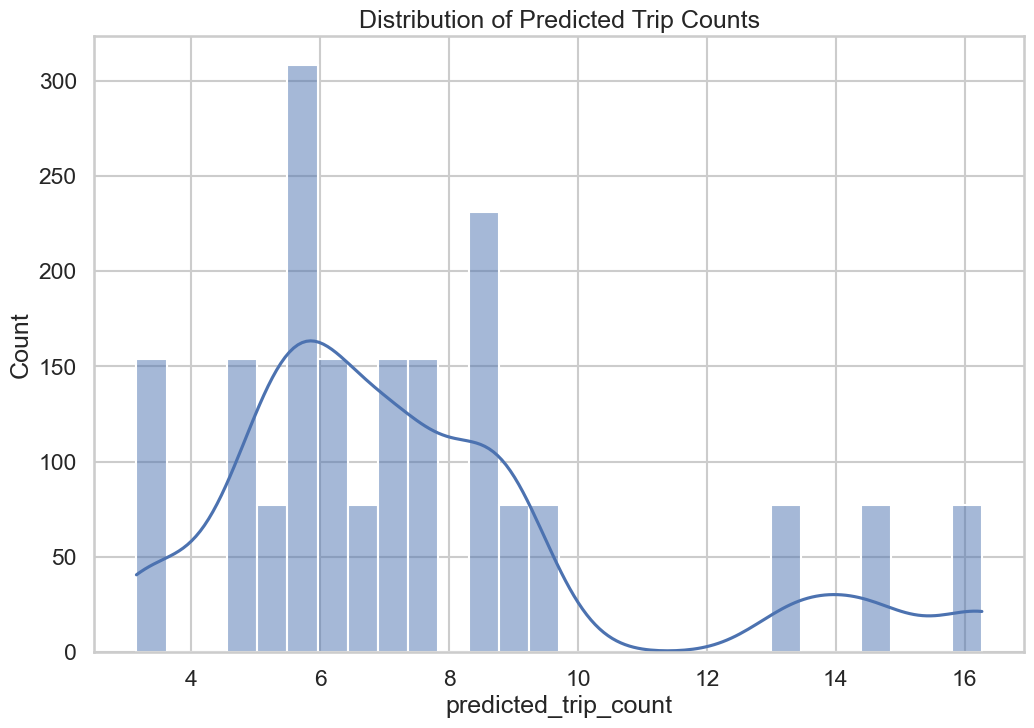

Prediction Variability by Zone:
                       count      mean       std       min       25%  \
pickup_community_area                                                  
1                       24.0  7.516363  3.239517  3.145699  5.638461   
2                       24.0  7.516363  3.239516  3.145700  5.638462   
3                       24.0  7.516363  3.239517  3.145700  5.638462   
4                       24.0  7.516363  3.239516  3.145700  5.638462   
5                       24.0  7.516363  3.239516  3.145700  5.638462   
...                      ...       ...       ...       ...       ...   
73                      24.0  7.516363  3.239516  3.145700  5.638462   
74                      24.0  7.516363  3.239516  3.145700  5.638462   
75                      24.0  7.516363  3.239516  3.145700  5.638462   
76                      24.0  7.516363  3.239516  3.145700  5.638462   
77                      24.0  7.516363  3.239516  3.145700  5.638462   

                            50%

In [30]:
# Check the input data schema
print("Input Data Schema:")
print(df_pred.info())

# Check for missing values
print("Missing Values:")
print(df_pred.isnull().sum())

# Check the distribution of predictions
print("Prediction Distribution:")
sns.histplot(df_pred['predicted_trip_count'], kde=True)
plt.title("Distribution of Predicted Trip Counts")
plt.show()

# Check variability across zones
print("Prediction Variability by Zone:")
print(df_pred.groupby('pickup_community_area')['predicted_trip_count'].describe())

In [32]:
# Check input data for predictions
print("Input Data Sample:")
print(df_pred.head())
print("Input Data Columns:")
print(df_pred.columns)

# Check if pickup_community_area is being used
if 'pickup_community_area' not in df_pred.columns:
    print("⚠️ 'pickup_community_area' is missing from the input data!")

# Check variability in predictions for a subset of zones
sample_zones = [8, 28, 32, 56, 76]
sample_data = df_pred[df_pred['pickup_community_area'].isin(sample_zones)]
print("Sample Data for Selected Zones:")
print(sample_data)

# Check predictions for the sample data
predictions = model.predict(sample_data)  # Replace with your model's prediction method
print("Predictions for Sample Data:")
print(predictions)

Input Data Sample:
   pickup_community_area            timestamp_hour hour day_of_week  \
0                      1 2025-04-16 12:00:00+00:00   12           2   
1                     10 2025-04-16 12:00:00+00:00   12           2   
2                     11 2025-04-16 12:00:00+00:00   12           2   
3                     12 2025-04-16 12:00:00+00:00   12           2   
4                     13 2025-04-16 12:00:00+00:00   12           2   

  is_weekend  predicted_trip_count  
0          0              8.579734  
1          0              8.579734  
2          0              8.579734  
3          0              8.579734  
4          0              8.579734  
Input Data Columns:
Index(['pickup_community_area', 'timestamp_hour', 'hour', 'day_of_week',
       'is_weekend', 'predicted_trip_count'],
      dtype='object')
Sample Data for Selected Zones:
      pickup_community_area            timestamp_hour hour day_of_week  \
20                       28 2025-04-16 12:00:00+00:00   12       

AttributeError: 'Model' object has no attribute 'predict'

## 8. Visualisation des Prévisions

Visualisons les prévisions pour les zones les plus actives.

Top zones: [76, 8, 32, 28, 56]
Unique values in df_pred['pickup_community_area'] before type conversion: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54 55 56 57 58 59  6 60 61 62 63 64 65 66 67 68 69  7 70 71 72 73 74
 75 76 77  8  9]
Unique values in df_pred['pickup_community_area'] after type conversion: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54 55 56 57 58 59  6 60 61 62 63 64 65 66 67 68 69  7 70 71 72 73 74
 75 76 77  8  9]
Filtered DataFrame shape: (120, 6)
Filtered DataFrame sample:     pickup_community_area            timestamp_hour hour day_of_week  \
20                     28 2025-04-16 12:00:00+00:00   12           2   
25                     32 2025-04-16 12:00:00+00:00   12           2   
51                     56 2025-04-16 12:00:00+00:00   12           2   


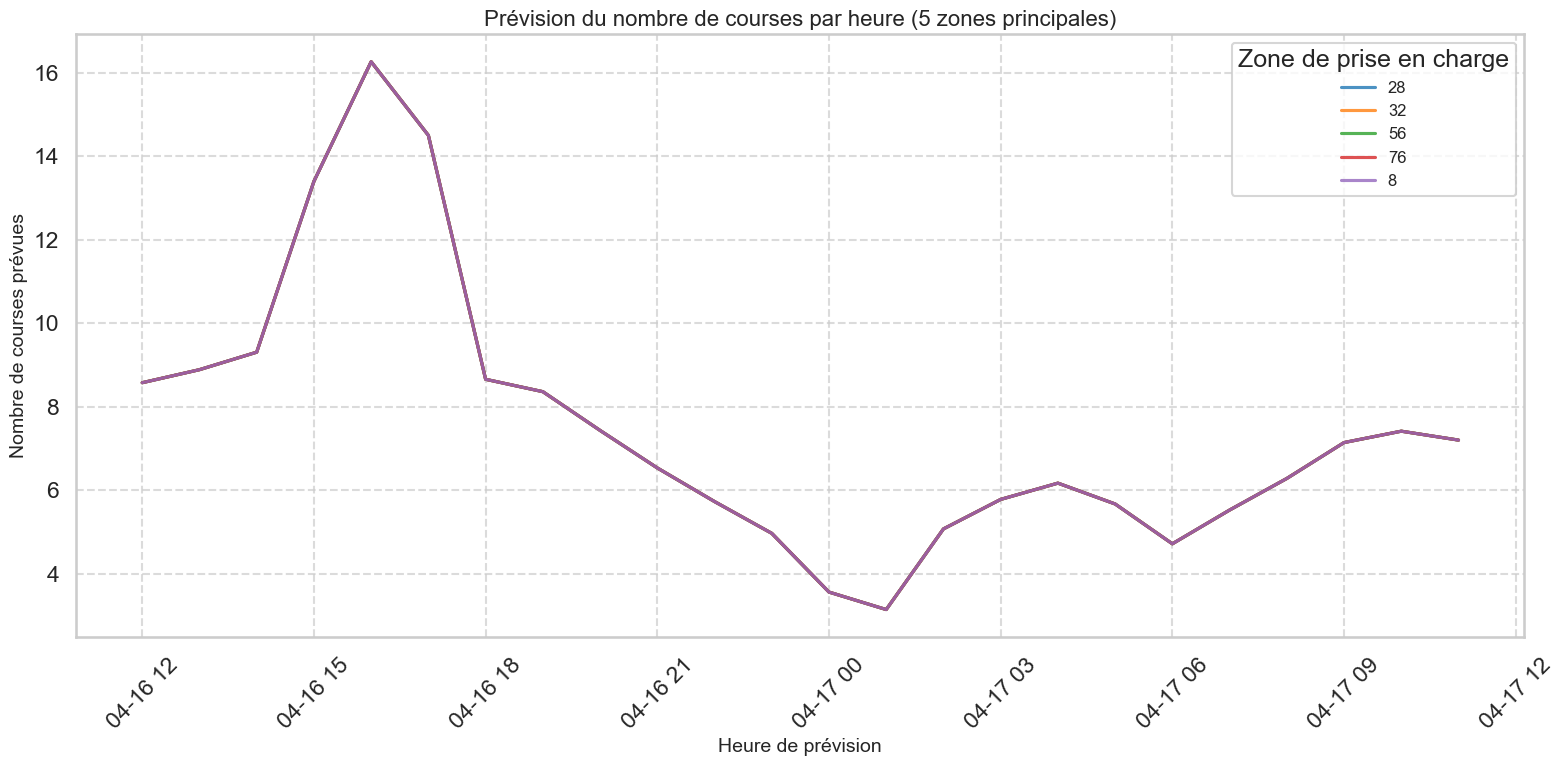

⚠️ Erreur lors de la visualisation des prévisions: Mime type rendering requires nbformat>=4.2.0 but it is not installed


In [29]:
# Identifier les zones les plus actives
top_zones_query = f"""
SELECT pickup_community_area, SUM(trip_count) as total_trips
FROM `{PROJECT_ID}.{BQ_DATASET}.demand_by_hour`
GROUP BY pickup_community_area
ORDER BY total_trips DESC
LIMIT 5
"""


try:
    # Récupérer les top zones
    top_zones_df = client.query(top_zones_query).to_dataframe()
    top_zones = top_zones_df['pickup_community_area'].tolist()
    print("Top zones:", top_zones)
    
    # Vérifier les valeurs uniques dans df_pred
    print("Unique values in df_pred['pickup_community_area'] before type conversion:", df_pred['pickup_community_area'].unique())
    
    # Assurez-vous que les types correspondent
    df_pred['pickup_community_area'] = df_pred['pickup_community_area'].astype(int)
    print("Unique values in df_pred['pickup_community_area'] after type conversion:", df_pred['pickup_community_area'].unique())
    
    # Filtrer les prédictions pour ces zones (utiliser .copy() pour éviter les warnings)
    df_filtered = df_pred[df_pred['pickup_community_area'].isin(top_zones)].copy()
    print("Filtered DataFrame shape:", df_filtered.shape)
    print("Filtered DataFrame sample:", df_filtered.head())
    
    # Vérifier les valeurs de predicted_trip_count
    print("Unique predicted_trip_count values by zone:")
    print(df_filtered.groupby('pickup_community_area')['predicted_trip_count'].unique())
    
    # Vérifier si df_filtered est vide
    if df_filtered.empty:
        print("⚠️ Le DataFrame filtré est vide. Vérifiez les données source.")
    else:
        # Convertir en chaîne de caractères
        df_filtered['pickup_community_area'] = df_filtered['pickup_community_area'].astype(str)
        print("Unique pickup_community_area values:", df_filtered['pickup_community_area'].unique())
        
        # Visualisation avec Matplotlib/Seaborn
        plt.figure(figsize=(16, 8))
        sns.lineplot(
            data=df_filtered, 
            x='timestamp_hour', 
            y='predicted_trip_count', 
            hue='pickup_community_area',
            palette='tab10',  # Use a wider color palette
            markers=True,     # Add markers to distinguish lines
            alpha=0.8         # Add transparency
        )
        plt.title('Prévision du nombre de courses par heure (5 zones principales)', fontsize=16)
        plt.xlabel('Heure de prévision', fontsize=14)
        plt.ylabel('Nombre de courses prévues', fontsize=14)
        plt.xticks(rotation=45)
        plt.legend(title='Zone de prise en charge', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Visualisation interactive avec Plotly
        fig = px.line(
            df_filtered, 
            x='timestamp_hour', 
            y='predicted_trip_count', 
            color='pickup_community_area',
            title='Prévision du nombre de courses par heure (interactive)',
            labels={
                'timestamp_hour': 'Heure de prévision',
                'predicted_trip_count': 'Nombre de courses prévues',
                'pickup_community_area': 'Zone de prise en charge'
            }
        )
        fig.update_layout(
            xaxis_title='Heure de prévision',
            yaxis_title='Nombre de courses prévues',
            legend_title='Zone',
            hovermode='x unified'
        )
        fig.show()
except Exception as e:
    print(f"⚠️ Erreur lors de la visualisation des prévisions: {e}")
    
    


## 9. Analyse des Patterns Horaires

Analysons les patterns horaires des prévisions.

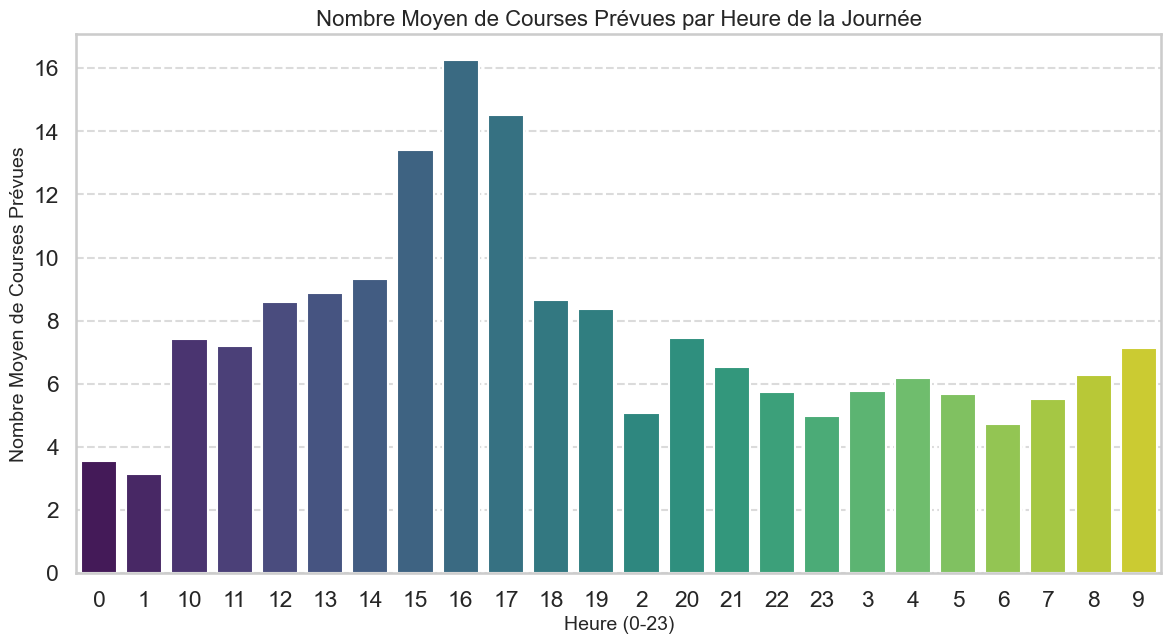

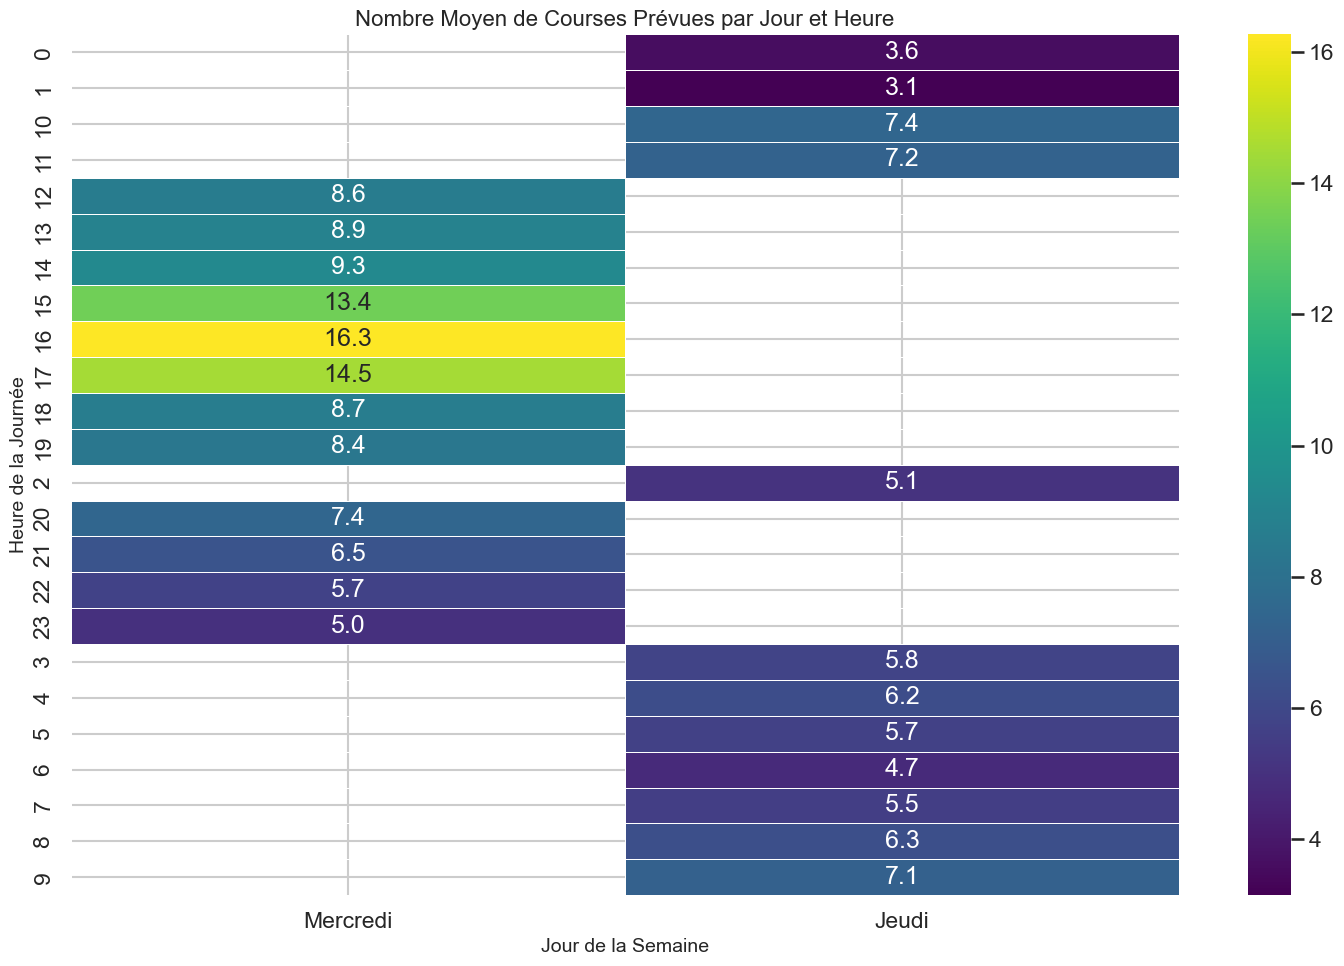

In [37]:
# Analyse par heure de la journée
try:
    # Agréger les prévisions par heure
    hourly_pred = df_pred.groupby('hour')['predicted_trip_count'].mean().reset_index()
    
    # Visualisation
    plt.figure(figsize=(14, 7))
    sns.barplot(x='hour', y='predicted_trip_count', data=hourly_pred, palette='viridis', hue='hour')
    plt.title('Nombre Moyen de Courses Prévues par Heure de la Journée', fontsize=16)
    plt.xlabel('Heure (0-23)', fontsize=14)
    plt.ylabel('Nombre Moyen de Courses Prévues', fontsize=14)
    plt.xticks(range(24))
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.show()
    
    # Analyse par jour de la semaine et heure
    day_hour_pred = df_pred.groupby(['day_of_week', 'hour'])['predicted_trip_count'].mean().reset_index()
    day_hour_pivot = day_hour_pred.pivot(index='hour', columns='day_of_week', values='predicted_trip_count')
    
    # Renommer les colonnes pour plus de clarté
    day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    day_hour_pivot.columns = [day_names[int(day)] for day in day_hour_pivot.columns]
    
    # Heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        day_hour_pivot, 
        cmap='viridis', 
        annot=True, 
        fmt='.1f',
        linewidths=0.5
    )
    plt.title('Nombre Moyen de Courses Prévues par Jour et Heure', fontsize=16)
    plt.xlabel('Jour de la Semaine', fontsize=14)
    plt.ylabel('Heure de la Journée', fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ Erreur lors de l'analyse des patterns horaires: {e}")

## 10. Analyse Spatiale des Prévisions

Analysons la distribution spatiale des prévisions par zone.

In [20]:
# Agrégation par zone
try:
    zone_pred = df_pred.groupby('pickup_community_area')['predicted_trip_count'].mean().reset_index()
    zone_pred = zone_pred.sort_values('predicted_trip_count', ascending=False)
    
    # Top 15 zones les plus actives
    top_15_zones = zone_pred.head(15)
    
    plt.figure(figsize=(16, 8))
    sns.barplot(
        x='pickup_community_area', 
        y='predicted_trip_count', 
        data=top_15_zones,
        palette='viridis'
    )
    plt.title('15 Zones avec le Plus Grand Nombre Moyen de Courses Prévues', fontsize=16)
    plt.xlabel('Zone (pickup_community_area)', fontsize=14)
    plt.ylabel('Nombre Moyen de Courses Prévues', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Distribution des prévisions à travers toutes les zones
    plt.figure(figsize=(12, 8))
    sns.histplot(zone_pred['predicted_trip_count'], bins=30, kde=True)
    plt.title('Distribution du Nombre Moyen de Courses Prévues par Zone', fontsize=16)
    plt.xlabel('Nombre Moyen de Courses Prévues', fontsize=14)
    plt.ylabel('Nombre de Zones', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
except Exception as e:
    print(f"⚠️ Erreur lors de l'analyse spatiale: {e}")

⚠️ Erreur lors de l'analyse spatiale: name 'df_pred' is not defined


## 11. Comparaison Weekend vs. Jours de Semaine

Comparons les prévisions pour les weekends et les jours de semaine.

In [21]:
try:
    # Agrégation par heure et weekend/semaine
    weekend_hourly = df_pred.groupby(['hour', 'is_weekend'])['predicted_trip_count'].mean().reset_index()
    
    # Visualisation
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=weekend_hourly, 
        x='hour', 
        y='predicted_trip_count', 
        hue='is_weekend',
        palette=['#1f77b4', '#ff7f0e'],
        markers=['o', 's'],
        style='is_weekend',
        linewidth=2.5
    )
    plt.title('Nombre Moyen de Courses Prévues par Heure: Weekend vs. Semaine', fontsize=16)
    plt.xlabel('Heure de la Journée', fontsize=14)
    plt.ylabel('Nombre Moyen de Courses Prévues', fontsize=14)
    plt.xticks(range(24))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(labels=['Semaine', 'Weekend'], title='Période')
    plt.show()
    
    # Comparaison pour les zones principales
    if 'top_zones' in locals():
        top_zone_weekend = df_pred[df_pred['pickup_community_area'].isin(top_zones[:3])]
        
        g = sns.FacetGrid(
            top_zone_weekend, 
            col='pickup_community_area', 
            hue='is_weekend',
            col_wrap=1, 
            height=4, 
            aspect=3,
            sharex=True
        )
        g.map(sns.lineplot, 'hour', 'predicted_trip_count')
        g.add_legend(labels=['Semaine', 'Weekend'])
        g.set_axis_labels('Heure de la Journée', 'Nombre de Courses Prévues')
        g.set_titles('Zone {col_name}')
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"⚠️ Erreur lors de la comparaison weekend vs. semaine: {e}")

⚠️ Erreur lors de la comparaison weekend vs. semaine: name 'df_pred' is not defined


## 12. Conclusion et Prochaines Étapes

### Résumé des Analyses
- Nous avons généré des prévisions de demande de taxis pour les périodes futures
- Les visualisations temporelles montrent des patterns clairs par heure et par jour
- L'analyse spatiale identifie les zones avec la plus forte demande prévue
- La comparaison weekend vs. semaine révèle des différences significatives dans les patterns de demande

### Insights Métier
- Les heures de pointe pour la demande de taxis sont principalement le matin et le soir en semaine
- Le weekend montre une demande plus élevée en soirée et la nuit
- Certaines zones ont une demande significativement plus élevée que d'autres
- Ces informations peuvent aider à optimiser l'allocation des taxis dans le temps et l'espace

### Prochaines Étapes
- Intégrer des données météorologiques et d'événements pour améliorer les prévisions
- Développer un tableau de bord en temps réel pour suivre les prévisions
- Explorer des stratégies d'optimisation de la flotte basées sur ces prévisions
- Évaluer et raffiner régulièrement le modèle avec de nouvelles données